# Hendrick Oscar Jimenez Garcia

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Cargar el dataset housing.csv
df = pd.read_csv('/content/drive/MyDrive/BUAP Ciencia Datos/Modulo 6/housing.csv')

# Limpieza de datos
df.replace(['---', '               ---', 'NaN', '', ' '], np.nan, inplace=True)

# Separar numéricas y categóricas
numeric_features = df.select_dtypes(include=np.number).columns
categorical_features = df.select_dtypes(exclude=np.number).columns

# Imputación: media para numéricas
numeric_imputer = SimpleImputer(strategy='mean')
df[numeric_features] = numeric_imputer.fit_transform(df[numeric_features])

In [13]:
# Escalado de datos
scaler = MinMaxScaler(feature_range=(0, 1))    ###transforma los datos en ceros y uno
# Only scale numeric features
numeric_features = df.select_dtypes(include=np.number).columns
df_scaled = scaler.fit_transform(df[numeric_features])  # Normalizar datos
train_scaled = scaler.fit_transform(df[numeric_features])


In [14]:
## Crear secuencias para LSTM
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 10
X, y = create_sequences(df_scaled, time_steps)

# División en entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [15]:
# Definir y compilar modelo
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, df_scaled.shape[1])),  # Change input_shape
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(df_scaled.shape[1])  # Change output Dense layer units
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mse') # You can adjust optimizer and loss function as needed

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Entrenamiento
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/20
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0176 - val_loss: 0.0084
Epoch 2/20
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0089 - val_loss: 0.0081
Epoch 3/20
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0084 - val_loss: 0.0079
Epoch 4/20
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 5/20
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 6/20
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 7/20
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0075 - val_loss: 0.0081
Epoch 8/20
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0075 - val_loss: 0.0077
Epoch 9/20
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0075 - val_loss: 0.0078
Epoch 10/20
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 11/20
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 12/

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


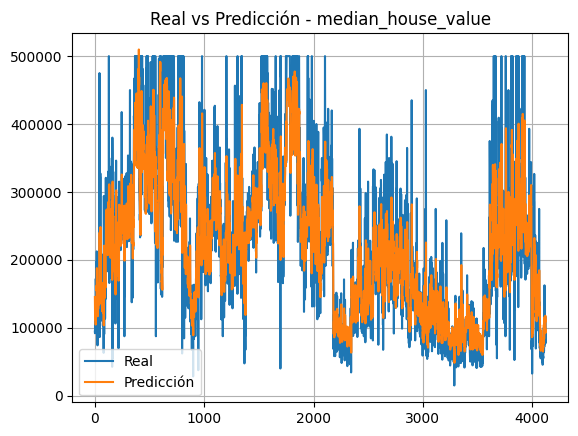

In [17]:
# Predicciones
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Desescalar predicciones

# Desescalar y_test
y_test_reshaped = y_test.reshape(-1, df_scaled.shape[1])
y_test_inverse = scaler.inverse_transform(y_test_reshaped)

# Elegir una columna para graficar (ej: median_house_value es la 8)
column_to_plot = 8
plt.plot(y_test_inverse[:, column_to_plot], label='Real')
plt.plot(predictions[:, column_to_plot], label='Predicción')
plt.title("Real vs Predicción - median_house_value")
plt.legend()
plt.grid(True)
plt.show()